## Quantum Machine Learning with Quantum Topological Data Analysis (QTDA)
Here we'll use QTDA to estimate Betti numbers to use as features to classify handwritten digits (0 vs 1).
We'll also be comparing different approaches used for making the classification model.

#### Notes:
* Estimated Betti numbers refer to numbers obtained from the quantum algorthm.
* All simulations in this notebook are performed on ideal devices without noise.
* Shots are not used in this notebook. Analytical results are used throughout.
* The notebook is meant to be run from start to end. There is frequent re-use of variable names.

In [1]:
# All imports
import os

os.environ["XLA_PYTHON_CLIENT_MEM_FRACTION"] = ".3"
from jax.config import config

config.update("jax_enable_x64", True)

import jax
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.datasets import load_digits
from classical_betti_calc import boundary, homology, betti
from utils import make_simplicies, gershgorin
from scipy.linalg import eigvals
import pennylane as qml
import jax.numpy as jnp
from jax.example_libraries.stax import Relu, Dense, serial
import optax
import time
import seaborn as sns

np.random.seed(0)

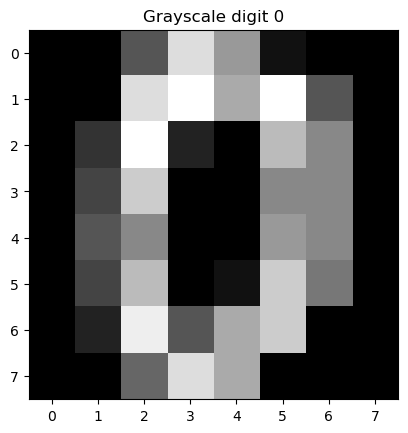

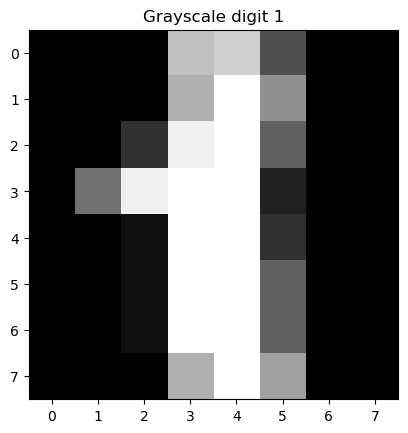

In [2]:
# Get digits data
data, targets = load_digits(return_X_y=True)
# We'll perform binary classificatin between 0 and 1
data = data[np.logical_or(targets == 0, targets == 1)]
targets = targets[np.logical_or(targets == 0, targets == 1)]

plt.imshow(data[0].reshape(8, 8), cmap="gray")
plt.title("Grayscale digit 0")
plt.show()
plt.imshow(data[1].reshape(8, 8), cmap="gray")
plt.title("Grayscale digit 1")
plt.show()

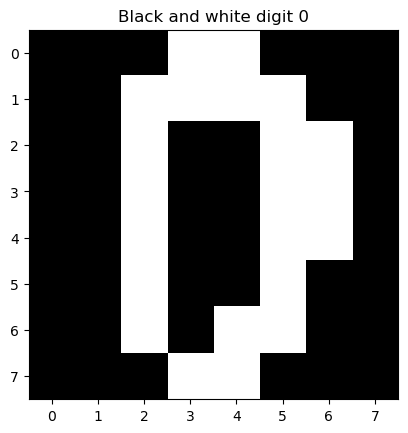

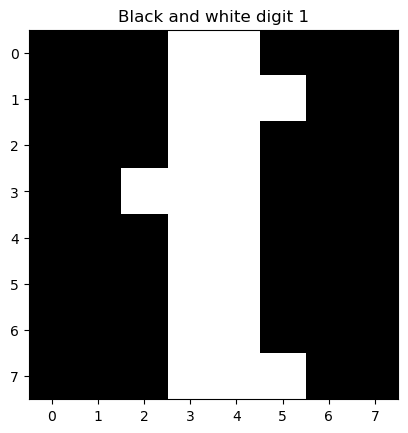

In [3]:
# We use black and white data with only two pixel values.
# Modify the images to be black and white
data[data < 8] = 0
data[data >= 8] = 1
data = data.reshape(len(data), 8, 8)

plt.imshow(data[0].reshape(8, 8), cmap="gray")
plt.title("Black and white digit 0")
plt.show()
plt.imshow(data[1].reshape(8, 8), cmap="gray")
plt.title("Black and white digit 1")
plt.show()

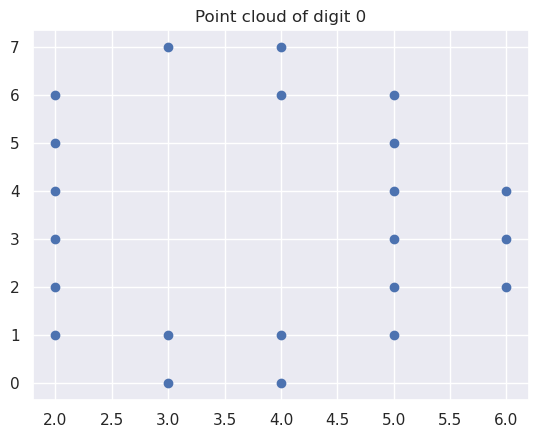

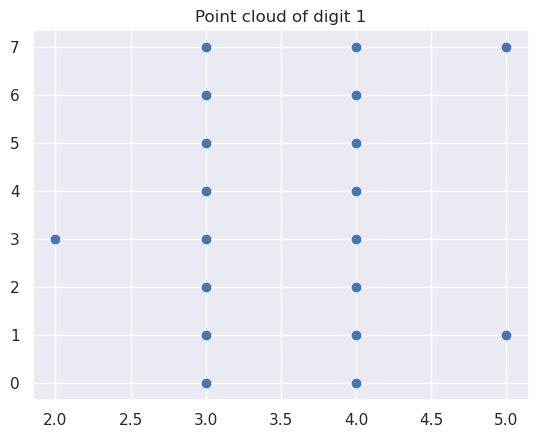

In [4]:
sns.set_theme()

# The pixels with value 1 are considered as vertices in a point cloud
def make_vertices(image):
    vertices = []
    for i, row in enumerate(image):
        for j, pixel in enumerate(row):
            if pixel > 0.5:
                vertices.append([j, i])
    return np.array(vertices)


v0 = make_vertices(data[0])
plt.scatter(x=v0[:, 0], y=v0[:, 1])
plt.title("Point cloud of digit 0")
plt.show()

v1 = make_vertices(data[1])
plt.scatter(x=v1[:, 0], y=v1[:, 1])
plt.title("Point cloud of digit 1")
plt.show()

In [5]:
# Make point clouds of all images
all_vertices = np.array([make_vertices(x) for x in data], dtype=object)

### For topological data analysis, we have some common steps

![Preprocessing Steps](common_steps.png)

![QTDA](qtda.png)

### First approach will be to use classical calculation of Betti number with classical ML models

![Approach_1](approach_1.png)

In [6]:
# Generate simplicial complexes of all point clouds.
# Here, edge length is taken as 2
scs = make_simplicies(all_vertices, 2, 3)
k = 1  # We'll estimate Betti number 1
all_combs = []
all_nums = []
all_bs = []
all_max_eigs = []
new_features = []
for i, sc in enumerate(scs):
    # Classical calculation of Betti numbers
    bnd, simplicies = boundary(sc)
    H = homology(bnd)
    b = betti(H)
    new_features.append([b[1]])  # We store Betti number 1 as the new feature

    comb_lap = bnd[k].T @ bnd[k] + bnd[k + 1] @ bnd[k + 1].T
    # This is another way to get the Betti number
    # We'll be estimating this value
    betti_k_zero_eig = np.count_nonzero(np.absolute(eigvals(comb_lap)) < 10**-7)

    # Nearest power of 2 to get the number of qubits that can simulate this
    num = int(np.ceil(np.log2(comb_lap.shape[0])))

    all_combs.append(comb_lap)
    all_nums.append(num)
    all_bs.append(betti_k_zero_eig)

    # The estimate of the maximal eigenvalue
    max_eig = max(gershgorin(comb_lap), 1)
    all_max_eigs.append(max_eig)

all_bs = np.array(all_bs)
new_features = np.array(new_features)

# Splitting the new features in training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    new_features, targets, test_size=0.3, stratify=targets, random_state=0
)

models = [
    LogisticRegression(random_state=0),
    RandomForestClassifier(random_state=0),
    SVC(random_state=0),
]
for model in models:
    model.fit(X_train, y_train)
    y_predict_test = model.predict(X_test)
    y_predict_train = model.predict(X_train)

    test_acc = accuracy_score(y_test, y_predict_test)
    train_acc = accuracy_score(y_train, y_predict_train)
    print(train_acc, test_acc)

0.9087301587301587 0.8796296296296297
0.9087301587301587 0.8796296296296297
0.9087301587301587 0.8796296296296297


### Second approach will be to use estimated Betti numbers obtained using QTDA with classical ML models


![approach_2](approach_2.png)

In [7]:
# Pad the combinatorial laplacians to make Hamiltonians that can be simulated with same number of qubits
t1 = time.time()
max_num = max(all_nums)  # The common number of qubits
all_H = [np.identity(2**max_num) * max_eig / 2 for max_eig in all_max_eigs]
for i, H in enumerate(all_H):
    all_H[i][: all_combs[i].shape[0], : all_combs[i].shape[0]] = all_combs[i]
    all_H[i] = all_H[i] / all_max_eigs[i] * 6
all_U = jax.vmap(jax.scipy.linalg.expm, in_axes=[0])(jnp.array(all_H) * 1j)
print(time.time() - t1)

2.428560733795166


In [8]:
# The number of qubits used for estimation in QPE
num_pre_qubits = 3

dev = qml.device(
    "default.qubit.jax",
    wires=2 * max_num + num_pre_qubits,  # Total number of qubits in the circuit
    shots=None,
)


@qml.qnode(dev, interface="jax")
def circ(unitary):
    for i in range(max_num):
        qml.Hadamard(max_num + i)
    for i in range(max_num):
        qml.CNOT([max_num + i, i])
    qml.QuantumPhaseEstimation(
        unitary,
        target_wires=range(max_num, 2 * max_num),
        estimation_wires=range(2 * max_num, 2 * max_num + num_pre_qubits),
    )
    return qml.probs(range(2 * max_num, 2 * max_num + num_pre_qubits))


circ_jit = jax.jit(circ)  # Jitted circuit


def get_q_betti(u):
    # Outputs the corresponding Betti number to unitary u
    return circ_jit(u)[0] * 2**max_num


def get_all_q_betti(us):
    # Outputs corresponding Betti numbers for all unitaries
    return jax.vmap(get_q_betti, in_axes=[0])(us)


print("starting qtda")
t1 = time.time()
# Betti number 1 for all unitaries corresponding to all images
all_q_bs = get_all_q_betti(all_U)
print(time.time() - t1)

starting qtda
3.76259183883667


In [9]:
# all_q_bs = np.array(all_q_bs)
print("Quantum Circuit for QTDA")
print(
    qml.draw(
        circ,
        show_all_wires=True,
        show_matrices=False,
        max_length=10000,
        expansion_strategy="device",
    )(all_U[0])
)

Quantum Circuit for QTDA
 0: ────╭X──────────────────────────────────────────────┤       
 1: ────│──╭X───────────────────────────────────────────┤       
 2: ────│──│──╭X────────────────────────────────────────┤       
 3: ────│──│──│──╭X─────────────────────────────────────┤       
 4: ────│──│──│──│──╭X──────────────────────────────────┤       
 5: ────│──│──│──│──│──╭X───────────────────────────────┤       
 6: ────│──│──│──│──│──│──╭X────────────────────────────┤       
 7: ──H─╰●─│──│──│──│──│──│──╭U(M0)─╭U(M1)─╭U(M2)───────┤       
 8: ──H────╰●─│──│──│──│──│──├U(M0)─├U(M1)─├U(M2)───────┤       
 9: ──H───────╰●─│──│──│──│──├U(M0)─├U(M1)─├U(M2)───────┤       
10: ──H──────────╰●─│──│──│──├U(M0)─├U(M1)─├U(M2)───────┤       
11: ──H─────────────╰●─│──│──├U(M0)─├U(M1)─├U(M2)───────┤       
12: ──H────────────────╰●─│──├U(M0)─├U(M1)─├U(M2)───────┤       
13: ──H───────────────────╰●─├U(M0)─├U(M1)─├U(M2)───────┤       
14: ──H──────────────────────╰●─────│──────│──────╭QFT†─┤ ╭Probs


In [10]:
print("Mean absolute error between estimated and actual Betti number 1")
print(sum(np.abs(all_q_bs - all_bs) / len(all_q_bs)))

Mean absolute error between estimated and actual Betti number 1
2.4012955910949225


In [11]:
all_q_bs = np.array(all_q_bs).reshape(-1, 1)

# Again splitting. This time using the Betti numbers estimated using QTDA
X_train, X_test, y_train, y_test = train_test_split(
    all_q_bs, targets, test_size=0.3, stratify=targets, random_state=0
)

models = [
    LogisticRegression(random_state=0),
    RandomForestClassifier(random_state=0),
    SVC(random_state=0),
]
for model in models:
    model.fit(X_train, y_train)
    y_predict_test = model.predict(X_test)
    y_predict_train = model.predict(X_train)

    test_acc = accuracy_score(y_test, y_predict_test)
    train_acc = accuracy_score(y_train, y_predict_train)
    print(train_acc, test_acc)

0.7817460317460317 0.7870370370370371
1.0 0.7037037037037037
0.7857142857142857 0.7592592592592593


### The shocase approach is to use QTDA as a subroutine with a variational quantum classifier combined with a classical neural network


![approach_3](approach_3.png)

In [12]:
targets = targets.reshape(-1, 1)

# Splitting the unitaries into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    all_U, targets, test_size=0.3, stratify=targets, random_state=0
)

In [13]:
num_layers = 3  # Number of layers in the variational classifier
epochs = 1000  # Number of epochs to train the classifier
lr = 0.1  # Learning rate for the optimiser
weights = np.random.uniform(
    -jnp.pi, jnp.pi, [num_layers, num_pre_qubits, 3]
)  # Random initial weights for the variational classifier
weights = jnp.array(weights)

In [14]:
@qml.qnode(dev, interface="jax")
def classifier_circuit(unitary, params):
    for i in range(max_num):
        qml.Hadamard(max_num + i)
    for i in range(max_num):
        qml.CNOT([max_num + i, i])
    qml.QuantumPhaseEstimation(
        unitary,
        target_wires=range(max_num, 2 * max_num),
        estimation_wires=range(2 * max_num, 2 * max_num + num_pre_qubits),
    )

    # The variational classifier attached to the QTDA circuit
    for i in range(num_layers):
        qml.broadcast(
            qml.U3,
            wires=range(2 * max_num, 2 * max_num + num_pre_qubits),
            pattern="single",
            parameters=params[i],
        )
        qml.broadcast(
            qml.CNOT,
            wires=range(2 * max_num, 2 * max_num + num_pre_qubits),
            pattern="ring",
        )

    return qml.probs(range(2 * max_num, 2 * max_num + num_pre_qubits))


# Classical dense layers at the end of the quantum circuit
init_fun, nn = serial(Dense(2**num_pre_qubits), Relu, Dense(1))
_, params_nn = init_fun(jax.random.PRNGKey(0), (2**num_pre_qubits,))

combined_weights = [weights, params_nn]  # All weights used for training


# The final classifier starting from the quantum circuit for QTDA to the variational classifier to classical neural network
@jax.jit
def circ_classifier(x, parameters):
    params, nn_params = parameters[0], parameters[1]
    probs = classifier_circuit(x, params)
    out = nn(nn_params, probs)
    out = jax.nn.sigmoid(out)
    return out

In [15]:
print("Quantum circuit of the classifier")
print(
    qml.draw(
        classifier_circuit,
        show_all_wires=True,
        show_matrices=False,
        max_length=10000,
        expansion_strategy="device",
    )(all_U[0], weights)
)
# The probabilities are fed into a classical neural network

Quantum circuit of the classifier
 0: ────╭X──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤       
 1: ────│──╭X───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤       
 2: ────│──│──╭X────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤       
 3: ────│──│──│──╭X─────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤       
 4: ────│──│──│──│──╭X──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤       
 5: ────│──│──│──│──│──╭X───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────┤       
 6: ────│──│──│──│──│──│

In [16]:
def cost(parameters, x):
    return circ_classifier(x, parameters)


def map_cost(parameters, x, y):
    logits = jax.vmap(cost, in_axes=[None, 0])(parameters, x)
    return jnp.mean(optax.sigmoid_binary_cross_entropy(logits, y))


def predict_one(x, parameters, s):
    ep = circ_classifier(x, parameters)
    return (ep >= s) + 0


def predict_all(x, parameters, s=0.5):
    return jax.vmap(predict_one, in_axes=[0, None, None])(x, parameters, s)

In [17]:
print("Scores before training:")
y_predict_train = predict_all(X_train, combined_weights)
y_predict_test = predict_all(X_test, combined_weights)
print(
    "Training Data:",
    accuracy_score(y_pred=y_predict_train, y_true=y_train),
    "Testing Data:",
    accuracy_score(y_pred=y_predict_test, y_true=y_test),
)

Scores before training:
Training Data: 0.503968253968254 Testing Data: 0.5092592592592593


In [18]:
original_parameters = combined_weights.copy()
train_costs = []
test_costs = []

In [19]:
def fit(params, optimizer):
    opt_state = optimizer.init(params)

    @jax.jit
    def step(params, opt_state, X, Y):
        grads = jax.grad(map_cost)(params, X, Y)
        updates, opt_state = optimizer.update(grads, opt_state, params)
        params = optax.apply_updates(params, updates)
        return params, opt_state

    for i in range(epochs):
        params, opt_state = step(params, opt_state, X_train, y_train)
        train_costs.append(map_cost(params, X_train, y_train))
        test_costs.append(map_cost(params, X_test, y_test))
        if i % 50 == 0:
            print(i, end="...")

    return params

Starting Optimization:
0...50...100...150...200...250...300...350...400...450...500...550...600...650...700...750...800...850...900...950...1000
Time taken for optimisation: 371.22948694229126 sec


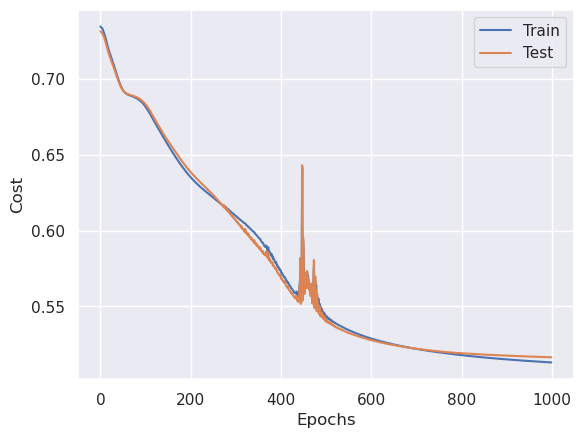

In [20]:
optimizer = optax.radam(lr)
t1 = time.time()
print("Starting Optimization:")
combined_weights = fit(combined_weights, optimizer)
print(epochs)
print("Time taken for optimisation:", time.time() - t1, "sec")

trained_parameters = combined_weights.copy()

plt.plot(train_costs)
plt.plot(test_costs)
plt.legend(["Train", "Test"])
plt.xlabel("Epochs")
plt.ylabel("Cost")
plt.show()

In [21]:
def get_split(params):
    all_predictions = jax.vmap(predict_all, in_axes=[None, None, 0])(
        X_train, params, np.linspace(0, 1, 101)
    )
    all_acc = [accuracy_score(y_train, predictions) for predictions in all_predictions]
    return all_acc, np.argmax(all_acc), np.linspace(0, 1, 101)[np.argmax(all_acc)]


accuracies, index, split = get_split(trained_parameters)

print("Scores after training:")
y_predict_train = predict_all(X_train, trained_parameters, split)
y_predict_test = predict_all(X_test, trained_parameters, split)
print(
    "Training Data:",
    accuracy_score(y_pred=y_predict_train, y_true=y_train),
    "Testing Data:",
    accuracy_score(y_pred=y_predict_test, y_true=y_test),
)

Scores after training:
Training Data: 0.9880952380952381 Testing Data: 0.9722222222222222


### Last approach considered is to use the estimated Betti numbers with a variational quantum classifier

![approach_4](approach_4.png)

In [22]:
dev_2 = qml.device("default.qubit.jax", wires=1, shots=None)
reupload_layers = 5  # Number of layers in the variational classifier
lr_direct = 0.01  # Learning rate
epoch_direct = 1000  # Number of epochs
np.random.seed(1)
direct_weights = np.random.uniform(-jnp.pi, jnp.pi, [reupload_layers, 3])
direct_weights = jnp.array(direct_weights)

# Splitting the estimated betti numbers
X_train, X_test, y_train, y_test = train_test_split(
    all_q_bs, targets, test_size=0.3, stratify=targets, random_state=0
)

In [23]:
# A simple single qubit classifier with data re-uploading
@qml.qnode(dev_2, interface="jax")
def direct_classifier(x, params):
    for i in range(reupload_layers):
        qml.RX(x, 0)
        qml.U3(*params[i], 0)
    return qml.probs(0)


# Classical neural network at the end of the quantum circuit
init_fun, nn_direct = serial(Dense(2), Relu, Dense(1))
_, params_nn_direct = init_fun(jax.random.PRNGKey(1), (2,))

combined_weights_direct = [direct_weights, params_nn_direct]

In [24]:
# Combined hybrid model
@jax.jit
def circ_classifier_direct(x, parameters):
    params, nn_params = parameters[0], parameters[1]
    probs = direct_classifier(x, params)
    out = nn(nn_params, probs)
    out = jax.nn.sigmoid(out)
    return out

In [25]:
# Single qubit variational classifier
print(
    qml.draw(
        direct_classifier,
        show_all_wires=True,
        show_matrices=False,
        max_length=10000,
        expansion_strategy="device",
    )(all_q_bs[0], direct_weights)
)

0: ──RX(M0)──U3(-0.52,1.38,-3.14)──RX(M0)──U3(-1.24,-2.22,-2.56)──RX(M0)──U3(-1.97,-0.97,-0.65)──RX(M0)──U3(0.24,-0.51,1.16)──RX(M0)──U3(-1.86,2.38,-2.97)─┤  Probs


In [26]:
def cost_direct(parameters, x):
    return circ_classifier_direct(x, parameters)


def map_cost_direct(parameters, x, y):
    logits = jax.vmap(cost_direct, in_axes=[None, 0])(parameters, x)
    return jnp.mean(optax.sigmoid_binary_cross_entropy(logits, y))


def predict_one_direct(x, parameters, s):
    ep = circ_classifier_direct(x, parameters)
    return (ep >= s) + 0


def predict_all_direct(x, parameters, s=0.5):
    return jax.vmap(predict_one_direct, in_axes=[0, None, None])(x, parameters, s)

In [27]:
print("Scores before training:")
y_predict_train = predict_all_direct(X_train, combined_weights_direct)
y_predict_test = predict_all_direct(X_test, combined_weights_direct)
print(
    "Training Data:",
    accuracy_score(y_pred=y_predict_train, y_true=y_train),
    "Testing Data:",
    accuracy_score(y_pred=y_predict_test, y_true=y_test),
)

Scores before training:
Training Data: 0.503968253968254 Testing Data: 0.5092592592592593


In [28]:
original_parameters_direct = combined_weights_direct.copy()
train_costs = []
test_costs = []


def fit_direct(params, optimizer):
    opt_state = optimizer.init(params)

    @jax.jit
    def step(params, opt_state, X, Y):
        grads = jax.grad(map_cost_direct)(params, X, Y)
        updates, opt_state = optimizer.update(grads, opt_state, params)
        params = optax.apply_updates(params, updates)
        return params, opt_state

    for i in range(epoch_direct):
        params, opt_state = step(params, opt_state, X_train, y_train)
        train_costs.append(map_cost_direct(params, X_train, y_train))
        test_costs.append(map_cost_direct(params, X_test, y_test))
        if i % 50 == 0:
            print(i, end="...")

    return params

Starting Optimization:
0...50...100...150...200...250...300...350...400...450...500...550...600...650...700...750...800...850...900...950...1000
Time taken for optimisation: 4.075592041015625 sec


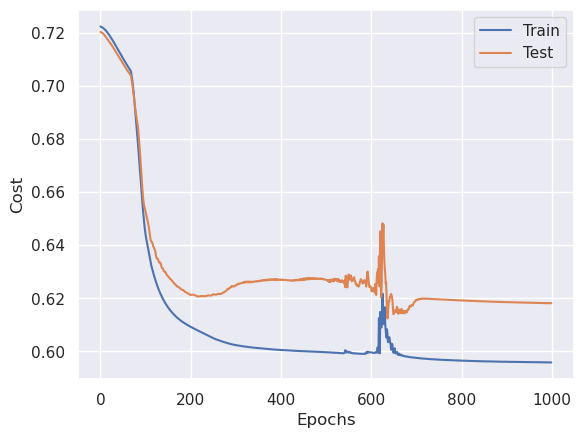

In [29]:
optimizer = optax.radam(lr)
t1 = time.time()
print("Starting Optimization:")
combined_weights_direct = fit_direct(combined_weights_direct, optimizer)
print(epoch_direct)
print("Time taken for optimisation:", time.time() - t1, "sec")

trained_parameters_direct = combined_weights_direct.copy()


plt.plot(train_costs)
plt.plot(test_costs)
plt.legend(["Train", "Test"])
plt.xlabel("Epochs")
plt.ylabel("Cost")
plt.show()

In [30]:
def get_split_direct(params):
    all_predictions = jax.vmap(predict_all_direct, in_axes=[None, None, 0])(
        X_train, params, np.linspace(0, 1, 101)
    )
    all_acc = [accuracy_score(y_train, predictions) for predictions in all_predictions]
    return all_acc, np.argmax(all_acc), np.linspace(0, 1, 101)[np.argmax(all_acc)]


accuracies_direct, index_direct, split_direct = get_split_direct(
    trained_parameters_direct
)

print("Scores after training:")
y_predict_train = predict_all_direct(X_train, trained_parameters_direct, split_direct)
y_predict_test = predict_all_direct(X_test, trained_parameters_direct, split_direct)
print(
    "Training Data:",
    accuracy_score(y_pred=y_predict_train, y_true=y_train),
    "Testing Data:",
    accuracy_score(y_pred=y_predict_test, y_true=y_test),
)

Scores after training:
Training Data: 0.8095238095238095 Testing Data: 0.7685185185185185


### We can also use the classical Betti numbers with this simple classifier

![approach_5](approach_5.png)

In [31]:
# Splitting the classical betti numbers
X_train, X_test, y_train, y_test = train_test_split(
    new_features, targets, test_size=0.3, stratify=targets, random_state=0
)

In [32]:
print("Scores before training:")
y_predict_train = predict_all_direct(X_train, original_parameters_direct)
y_predict_test = predict_all_direct(X_test, original_parameters_direct)
print(
    "Training Data:",
    accuracy_score(y_pred=y_predict_train, y_true=y_train),
    "Testing Data:",
    accuracy_score(y_pred=y_predict_test, y_true=y_test),
)

Scores before training:
Training Data: 0.503968253968254 Testing Data: 0.5092592592592593


Starting Optimization:
0...50...100...150...200...250...300...350...400...450...500...550...600...650...700...750...800...850...900...950...1000
Time taken for optimisation: 3.958218812942505 sec


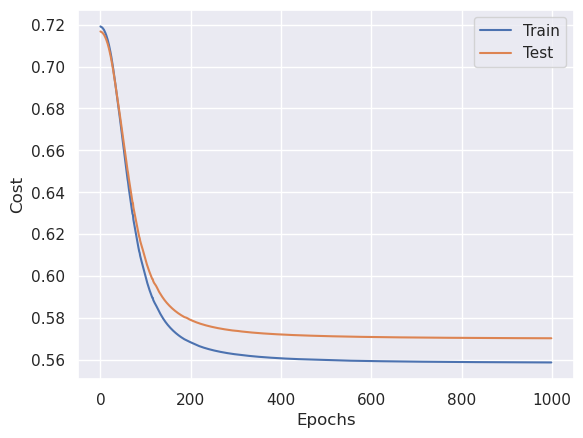

In [33]:
train_costs = []
test_costs = []

optimizer = optax.radam(lr)
t1 = time.time()
print("Starting Optimization:")
combined_weights_direct = fit_direct(original_parameters_direct, optimizer)
print(epoch_direct)
print("Time taken for optimisation:", time.time() - t1, "sec")

trained_parameters_direct = combined_weights_direct.copy()

plt.plot(train_costs)
plt.plot(test_costs)
plt.legend(["Train", "Test"])
plt.xlabel("Epochs")
plt.ylabel("Cost")
plt.show()

In [34]:
accuracies_direct, index_direct, split_direct = get_split_direct(
    trained_parameters_direct
)

print("Scores after training:")
y_predict_train = predict_all_direct(X_train, trained_parameters_direct, split_direct)
y_predict_test = predict_all_direct(X_test, trained_parameters_direct, split_direct)
print(
    "Training Data:",
    accuracy_score(y_pred=y_predict_train, y_true=y_train),
    "Testing Data:",
    accuracy_score(y_pred=y_predict_test, y_true=y_test),
)

Scores after training:
Training Data: 0.9087301587301587 Testing Data: 0.8796296296296297


### The best testing accuracy (0.972) was achieved when using the hybrid model where QTDA was used as a subroutine with a variational quantum classifier and classical neural network.